In [1]:
import numpy as np
import pandas as pd
import json

from pathlib import Path
import os.path
import multiprocessing as mp

import matplotlib.pyplot as plt
import seaborn as sns
import PIL

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard, ModelCheckpoint

from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler

In [2]:
IMG_SIZE = (224,224) # Image resolution
BATCH_SIZE = 32
NUM_OF_CHANNELS = 3 
NUM_PROCESSES = 6

In [3]:
pool = mp.Pool(processes=NUM_PROCESSES)

In [4]:
image_dir = Path('../input/food41/images')

In [5]:
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
train_df, test_df = train_test_split(image_df, train_size=0.75, shuffle=True, random_state=1)

In [7]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)


In [8]:
train_data = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=IMG_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 60600 validated image filenames belonging to 101 classes.
Found 15150 validated image filenames belonging to 101 classes.
Found 25250 validated image filenames belonging to 101 classes.


In [9]:
data_augmentation = tf.keras.Sequential([
     tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_SIZE[0], 
                                                              IMG_SIZE[1],
                                                              NUM_OF_CHANNELS)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
])

In [10]:
model = tf.keras.Sequential([
        data_augmentation,
        tf.keras.applications.EfficientNetB0(
            input_shape=(IMG_SIZE[0], IMG_SIZE[1], NUM_OF_CHANNELS),
            weights='imagenet',
            include_top=False,
            drop_connect_rate=0.5
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(101, activation='softmax') 
])

16711680/16705208 [==============================] - 0s 0us/step


In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


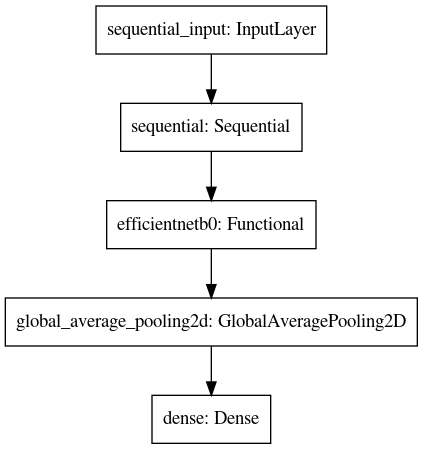

In [12]:
tf.keras.utils.plot_model(model)

In [13]:
opt = Adam(learning_rate=0.001)

model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy']) 

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',patience = 1,verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss',patience = 5,verbose = 1,restore_best_weights = True)
checkpointer = ModelCheckpoint('model5a.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('model5a.log')

history = model.fit(
    train_data, 
    validation_data=val_data,
    epochs= 7,
    callbacks=[early_stop, csv_logger , reduce_lr, checkpointer]
)

Epoch 1/7
1894/1894 [==============================] - 768s 400ms/step - loss: 2.4504 - accuracy: 0.4073 - val_loss: 1.6528 - val_accuracy: 0.5765

Epoch 00001: val_loss improved from inf to 1.65285, saving model to model5a.01-1.65.hdf5
Epoch 2/7
1894/1894 [==============================] - 510s 269ms/step - loss: 1.3021 - accuracy: 0.6568 - val_loss: 1.7684 - val_accuracy: 0.5697

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_loss did not improve from 1.65285
Epoch 3/7
1894/1894 [==============================] - 519s 274ms/step - loss: 0.8839 - accuracy: 0.7629 - val_loss: 0.9472 - val_accuracy: 0.7517

Epoch 00003: val_loss improved from 1.65285 to 0.94724, saving model to model5a.03-0.95.hdf5
Epoch 4/7
1894/1894 [==============================] - 517s 273ms/step - loss: 0.6983 - accuracy: 0.8113 - val_loss: 0.9059 - val_accuracy: 0.7612

Epoch 00004: val_loss improved from 0.94724 to 0.90587, saving model to model5a.04-0.91.hdf5


In [14]:
results = model.evaluate(test_data, verbose=0)
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 76.13%


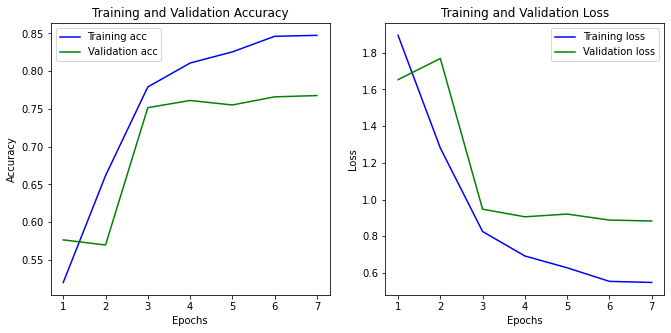

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(11, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [16]:
predictions = np.argmax(model.predict(test_data), axis=1)

cm = confusion_matrix(test_data.labels, predictions)
clr = classification_report(test_data.labels, predictions, target_names=test_data.class_indices, zero_division=0)

In [17]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                          precision    recall  f1-score   support

              apple_pie       0.56      0.53      0.54       265
         baby_back_ribs       0.73      0.72      0.72       254
                baklava       0.77      0.86      0.81       241
         beef_carpaccio       0.77      0.84      0.80       211
           beef_tartare       0.83      0.61      0.71       244
             beet_salad       0.68      0.68      0.68       259
               beignets       0.83      0.82      0.82       242
               bibimbap       0.93      0.82      0.87       259
          bread_pudding       0.60      0.59      0.60       259
      breakfast_burrito       0.74      0.64      0.69       273
             bruschetta       0.69      0.73      0.71       211
           caesar_salad       0.82      0.83      0.82       248
                cannoli       0.88      0.80      0.84       277
          caprese_salad       0.69      0.

Text(105.0, 0.5, 'Truth')

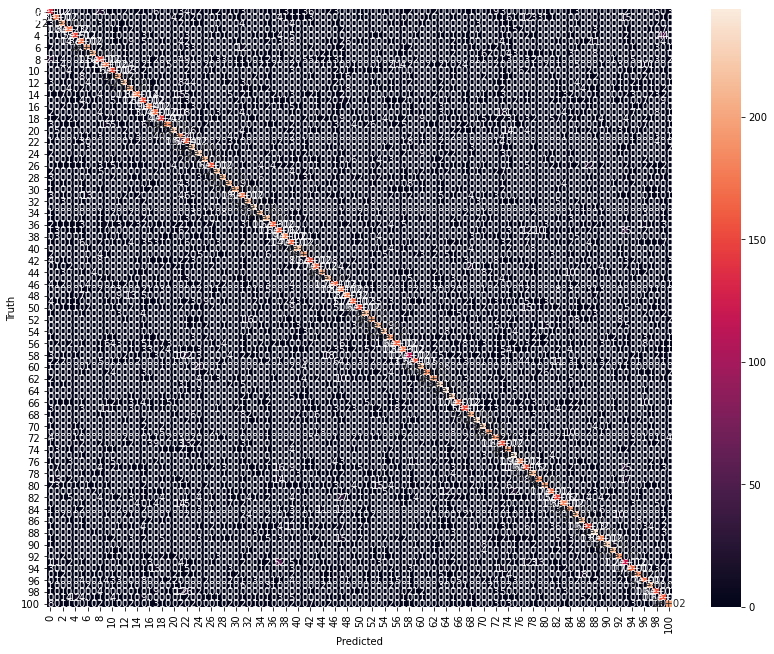

In [18]:
plt.figure(figsize = (14,11))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

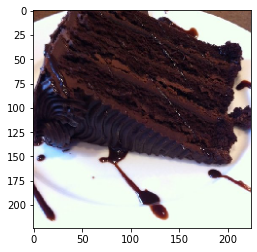

In [19]:
img_path = '../input/food41/images/chocolate_cake/1001084.jpg'
img = image.load_img(img_path, target_size=IMG_SIZE)
plt.imshow(img)
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = tf.keras.applications.efficientnet.preprocess_input(img_batch)

In [20]:
Categories = sorted(os.listdir('../input/food41/images'))
Categories

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [21]:
Categories[21]

'chocolate_cake'

In [22]:
Categories[np.argmax(model.predict([img_preprocessed]))]

'chocolate_cake'

In [23]:
columns = {
    'data_columns' : [col for col in Categories]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))